In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/archive.zip" /content/
!unzip "/content/archive.zip" -d /content/CBIS-DDSM

Streaming output truncated to the last 5000 lines.
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: /content/CBIS-DDSM/jpeg/

In [ ]:
!ls "/content/CBIS-DDSM/csv"

calc_case_description_test_set.csv   mass_case_description_test_set.csv
calc_case_description_train_set.csv  mass_case_description_train_set.csv
dicom_info.csv			     meta.csv


In [ ]:
!pip install tensorflow pandas matplotlib

In [ ]:
!ls "/content/CBIS-DDSM/csv"

calc_case_description_test_set.csv   mass_case_description_test_set.csv
calc_case_description_train_set.csv  mass_case_description_train_set.csv
dicom_info.csv			     meta.csv


In [ ]:
import os
import gc
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm
from scipy.special import gamma

import keras
from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint, CSVLogger
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import EfficientNetV2B0

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
#This is laying the groundwork for: Filtering relevant images, Linking metadata to images, Using image paths later for loading into the model
CSV_PATH = '/content/CBIS-DDSM/csv/dicom_info.csv'
metadata = pd.read_csv(CSV_PATH)
print(metadata.head())

                                           file_path  \
0  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...   
1  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...   
2  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...   
3  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   
4  CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...   

                                          image_path  AccessionNumber  \
0  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...              NaN   
1  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...              NaN   
2  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...              NaN   
3  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   
4  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...              NaN   

   BitsAllocated  BitsStored BodyPartExamined  Columns  ContentDate  \
0             16          16           BREAST      351     20160426   
1             16          16           BREAST     3526     20160426   
2          

In [ ]:
#It's listing and printing out all the image filenames from the subfolders inside /content/CBIS-DDSM/jpeg.
path = "/content/CBIS-DDSM/jpeg"

for files in os.listdir(path):
    files_dir = os.path.join(path, files)

    if files == 'jpeg':
        pass
    else:
        for file in os.listdir(files_dir):
            print(file)

1-147.jpg
1-226.jpg
1-275.jpg
2-274.jpg
1-053.jpg
2-294.jpg
1-187.jpg
2-002.jpg
1-003.jpg
2-143.jpg
1-142.jpg
1-277.jpg
2-255.jpg
2-292.jpg
1-291.jpg
1-064.jpg
1-103.jpg
1-199.jpg
2-051.jpg
1-113.jpg
1-083.jpg
2-082.jpg
1-076.jpg
2-027.jpg
1-266.jpg
1-032.jpg
2-167.jpg
1-173.jpg
2-196.jpg
1-271.jpg
1-192.jpg
2-193.jpg
1-188.jpg
2-166.jpg
1-075.jpg
2-202.jpg
1-225.jpg
1-057.jpg
2-032.jpg
1-180.jpg
1-012.jpg
1-062.jpg
2-204.jpg
1-099.jpg
1-251.jpg
2-043.jpg
1-065.jpg
2-139.jpg
1-138.jpg
1-289.jpg
1-129.jpg
2-108.jpg
1-079.jpg
2-206.jpg
1-228.jpg
1-069.jpg
2-047.jpg
1-125.jpg
1-129.jpg
1-227.jpg
2-079.jpg
2-260.jpg
1-078.jpg
1-064.jpg
2-037.jpg
2-080.jpg
1-031.jpg
1-234.jpg
1-248.jpg
2-170.jpg
1-005.jpg
2-283.jpg
1-293.jpg
1-126.jpg
2-127.jpg
1-020.jpg
2-158.jpg
1-157.jpg
1-152.jpg
2-151.jpg
1-010.jpg
1-130.jpg
1-194.jpg
1-230.jpg
2-028.jpg
2-082.jpg
1-104.jpg
1-046.jpg
1-127.jpg
2-188.jpg
1-210.jpg
1-213.jpg
2-066.jpg
1-065.jpg
1-095.jpg
2-203.jpg
2-268.jpg
1-160.jpg
2-291.jpg
1-013.jpg


In [ ]:
dicom_df = pd.read_csv("/content/CBIS-DDSM/csv/dicom_info.csv")
dicom_df.describe().T

count          mean           std           min  \
AccessionNumber              0.0           NaN           NaN           NaN   
BitsAllocated            10237.0  1.321246e+01      3.812001  8.000000e+00   
BitsStored               10237.0  1.321246e+01      3.812001  8.000000e+00   
Columns                  10237.0  2.179893e+03   1374.221082  6.800000e+01   
ContentDate              10237.0  2.016047e+07    111.049745  2.016041e+07   
ContentTime              10237.0  1.230613e+05  11391.443116  8.275551e+04   
HighBit                  10237.0  1.221246e+01      3.812001  7.000000e+00   
InstanceNumber           10237.0  1.000000e+00      0.000000  1.000000e+00   
LargestImagePixelValue   10237.0  4.261229e+04  30995.808636  2.550000e+02   
PatientBirthDate             0.0           NaN           NaN           NaN   
PatientSex                   0.0           NaN           NaN           NaN   
PixelRepresentation      10237.0  0.000000e+00      0.000000  0.000000e+00   
ReferringPhysicianName       0.0           NaN           NaN           NaN   
Rows                     10237.0  3.549779e+03   2363.196643  7.300000e+01   
SamplesPerPixel          10237.0  1.000000e+00      0.000000  1.000000e+00   
SeriesNumber             10237.0  1.000000e+00      0.000000  1.000000e+00   
SmallestImagePixelValue  10237.0  9.294026e+03  15367.554560  0.000000e+00   
StudyDate                 9671.0  2.016440e+07   4831.297763  2.016072e+07   
StudyTime                 9671.0  1.578644e+05  51545.806583  8.223500e+04   

                                  25%           50%           75%  \
AccessionNumber                   NaN           NaN           NaN   
BitsAllocated            8.000000e+00  1.600000e+01  1.600000e+01   
BitsStored               8.000000e+00  1.600000e+01  1.600000e+01   
Columns                  4.530000e+02  2.728000e+03  3.112000e+03   
ContentDate              2.016043e+07  2.016050e+07  2.016050e+07   
ContentTime              1.137396e+05  1.229359e+05  1.322114e+05   
HighBit                  7.000000e+00  1.500000e+01  1.500000e+01   
InstanceNumber           1.000000e+00  1.000000e+00  1.000000e+00   
LargestImagePixelValue   2.550000e+02  6.553500e+04  6.553500e+04   
PatientBirthDate                  NaN           NaN           NaN   
PatientSex                        NaN           NaN           NaN   
PixelRepresentation      0.000000e+00  0.000000e+00  0.000000e+00   
ReferringPhysicianName            NaN           NaN           NaN   
Rows                     4.410000e+02  4.624000e+03  5.476000e+03   
SamplesPerPixel          1.000000e+00  1.000000e+00  1.000000e+00   
SeriesNumber             1.000000e+00  1.000000e+00  1.000000e+00   
SmallestImagePixelValue  0.000000e+00  0.000000e+00  1.968700e+04   
StudyDate                2.016072e+07  2.016081e+07  2.017083e+07   
StudyTime                9.074250e+04  1.703350e+05  2.148190e+05   

                                  max  
AccessionNumber                   NaN  
BitsAllocated            1.600000e+01  
BitsStored               1.600000e+01  
Columns                  5.431000e+03  
ContentDate              2.017092e+07  
ContentTime              1.605079e+05  
HighBit                  1.500000e+01  
InstanceNumber           1.000000e+00  
LargestImagePixelValue   6.553500e+04  
PatientBirthDate                  NaN  
PatientSex                        NaN  
PixelRepresentation      0.000000e+00  
ReferringPhysicianName            NaN  
Rows                     7.111000e+03  
SamplesPerPixel          1.000000e+00  
SeriesNumber             1.000000e+00  
SmallestImagePixelValue  5.953800e+04  
StudyDate                2.017093e+07  
StudyTime                2.245020e+05

In [ ]:
dicom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [ ]:
dicom_df.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [ ]:
dicom_df.SeriesDescription.value_counts()

SeriesDescription
cropped images           3567
ROI mask images          3247
full mammogram images    2857
Name: count, dtype: int64

In [ ]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [ ]:
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
full_mammogram.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [ ]:
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path
roi_mask.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [ ]:
# # delete dicom_df after finished use it
del dicom_df;    gc.collect()

4

In [ ]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [ ]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
correct_dir = "/content/CBIS-DDSM/jpeg"

In [ ]:
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

Cropped Images paths:
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


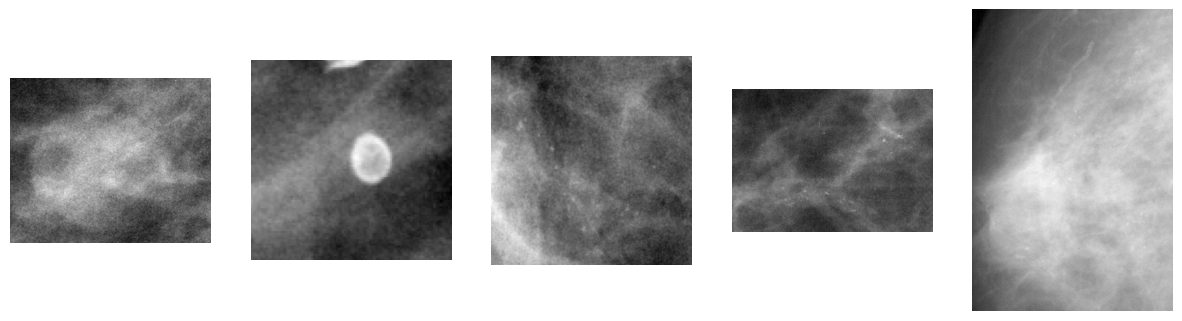

In [ ]:
plot_smaples(cropped_images, 15, 15)

In [ ]:
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0])


Full mammo Images paths:
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


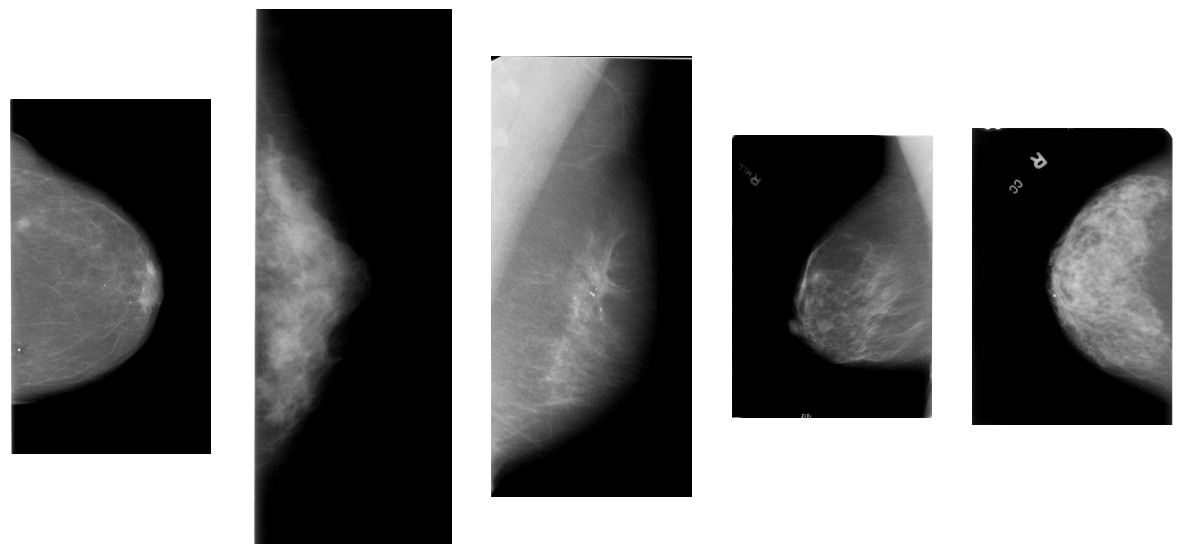

In [ ]:
plot_smaples(full_mammogram)

In [ ]:
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


ROI Mask Images paths:
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


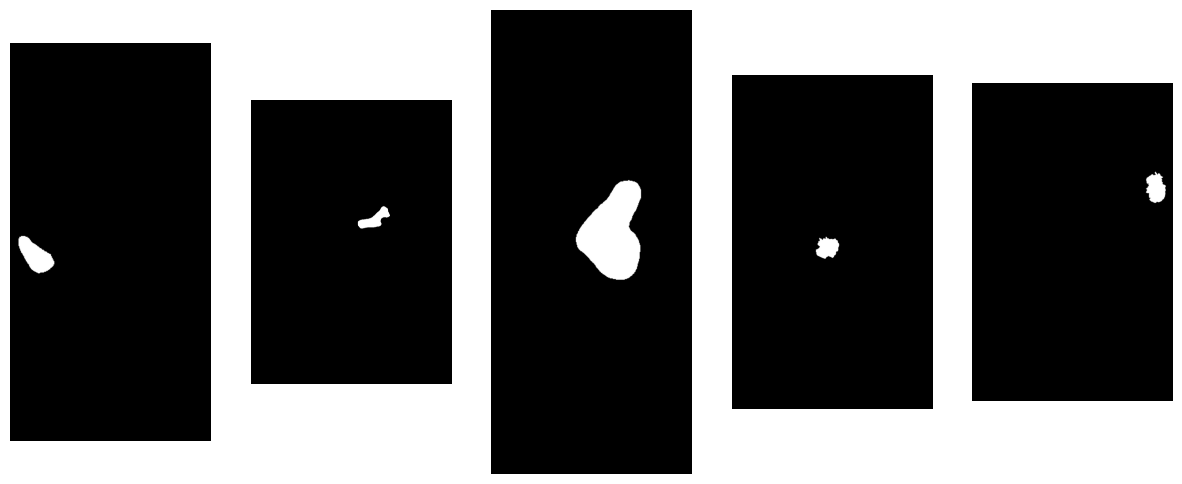

In [ ]:
plot_smaples(roi_mask)

In [ ]:
def get_image_file_name(data, new_dict):
    """
    /input
    /cbis-ddsm-breast-cancer-image-dataset
    /jpeg
    /1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304 [5]
    /1-172.jpg

    return path at index [5] after split depends on split('\')
    """
    for dicom in data:
        key = dicom.split('/')[4]
#         print(key)
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [ ]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [ ]:
next(iter((cropped_images.items())))

(0,
 '/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg')

In [ ]:
next(iter((cropped_images_dict.items())))
print()
print(len(cropped_images_dict.keys()))


3567


In [ ]:
next(iter((roi_img_dict.items())))
print()
print(len(roi_img_dict.keys()))


3247


In [ ]:
del cropped_images, full_mammogram, roi_mask;    gc.collect()

21756

In [ ]:
#Data preprocessing/path correction
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):

        img_name = image[11].split('/')[2]

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None

        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]

        else:
            data.iloc[indx, 13] = None

In [ ]:
mass_train = pd.read_csv("/content/CBIS-DDSM/csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv("/content/CBIS-DDSM/csv/mass_case_description_test_set.csv")

In [ ]:
mass_train.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

In [ ]:
mass_train.iloc[:, 11].head()

0    Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...
1    Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...
2    Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...
3    Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...
4    Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...
Name: image file path, dtype: object

In [ ]:
fix_image_path(mass_train)

In [ ]:
mass_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [ ]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
1  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
2  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
3  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
4  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   

                             cropped_image_file_path  \
0  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
1  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
2  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
3  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
4  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   

                                  ROI_mask_file_path  
0  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
1  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
2  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
3  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
4  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...

In [ ]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [ ]:
mass_test.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality type mass shape   mass margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image file path  \
0  Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...   
3  Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...   
4  Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...   

                             cropped image file path  \
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....   

                                  ROI mask file path  
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....  
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....

In [ ]:
mass_train.iloc[:, 11].head()

0    /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...
1    /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...
2    /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...
3    /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...
4    /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...
Name: image_file_path, dtype: object

In [ ]:
fix_image_path(mass_test)

In [ ]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns
mass_test.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image_file_path  \
0  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
1  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
2  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
3  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
4  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   

                             cropped_image_file_path  \
0  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
1  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
2  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
3  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   
4  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...   

                                  ROI_mask_file_path  
0  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
1  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
2  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
3  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...  
4  /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1...

In [ ]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [ ]:
calc_train = pd.read_csv("/content/CBIS-DDSM/csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv("/content/CBIS-DDSM/csv/calc_case_description_test_set.csv")

In [ ]:
calc_train.iloc[:,11].head()

0    Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...
1    Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...
2    Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...
3    Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...
4    Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...
Name: image file path, dtype: object

In [ ]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
calc_train.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image_file_path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped_image_file_path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI_mask_file_path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [ ]:
fix_image_path(calc_train)

In [ ]:
calc_test.iloc[:,11].head()

0    Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...
1    Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...
2    Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...
3    Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...
4    Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...
Name: image file path, dtype: object

In [ ]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})

calc_test.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality_type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety  \
0                   BENIGN         2   
1                   BENIGN         2   
2  BENIGN_WITHOUT_CALLBACK         5   
3  BENIGN_WITHOUT_CALLBACK         5   
4  BENIGN_WITHOUT_CALLBACK         5   

                                     image_file_path  \
0  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
4  Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                             cropped_image_file_path  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....   
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....   
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                  ROI_mask_file_path  
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....  
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....  
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...

In [ ]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):
        # Check if image[11] is not None before splitting
        if image[11] is not None:
            img_name = image[11].split('/')[2]
        else:
            # Handle the None value, e.g., skip or assign a default value
            print(f"Warning: None value encountered at index {indx} for image file path. Skipping.")
            continue  # Skip to the next row

        # ... rest of your code (similar checks for image[12] and image[13]) ...

In [ ]:
print(f'Shape of mass_train: {calc_train.shape}')
print(f'Shape of mass_test: {calc_test.shape}')

Shape of mass_train: (1546, 14)
Shape of mass_test: (326, 14)


In [ ]:
def display_images(dataset, column, number):



    fig, axes = plt.subplots(1, number, figsize=(15, 5))


    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]


        if image_path is None or not os.path.exists(image_path):

            continue

        image = cv2.imread(image_path)


        if image is None:

            continue


        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
        print(np.array(image).shape)

    plt.tight_layout()
    plt.show()

Full Mammograms:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


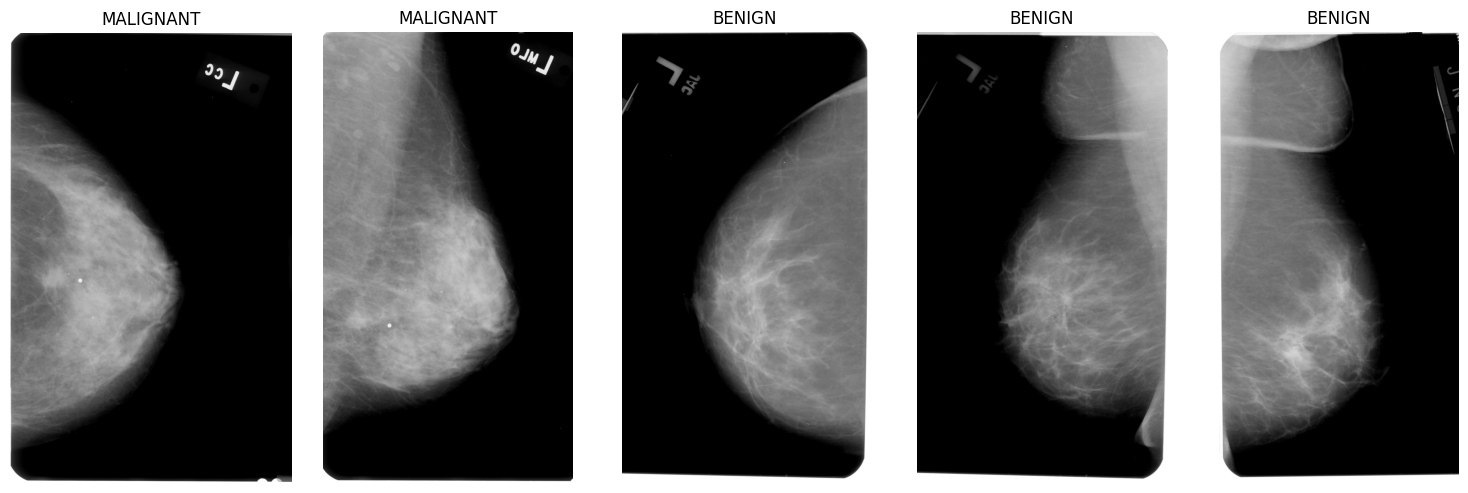

Cropped Mammograms:

(515, 431, 3)
(292, 256, 3)
(466, 423, 3)
(427, 422, 3)
(399, 465, 3)


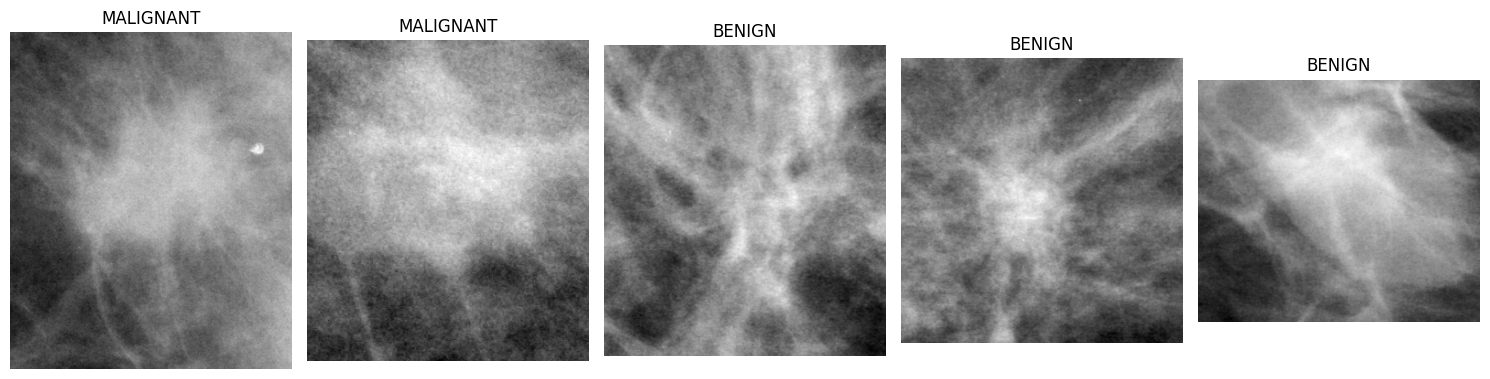

ROI_mask:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


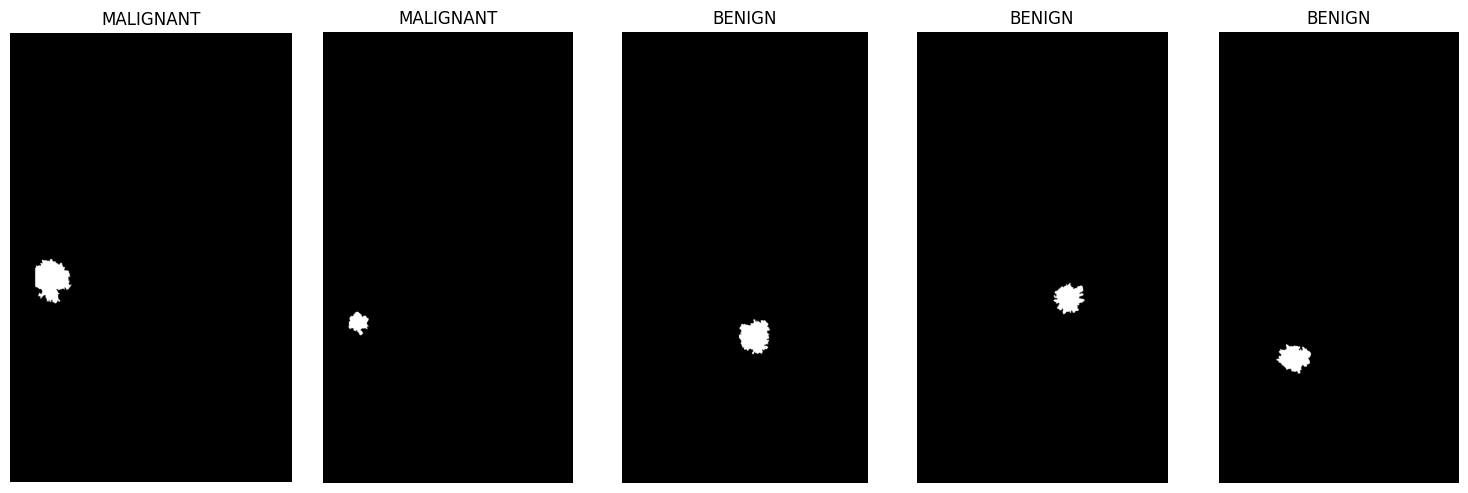

In [ ]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


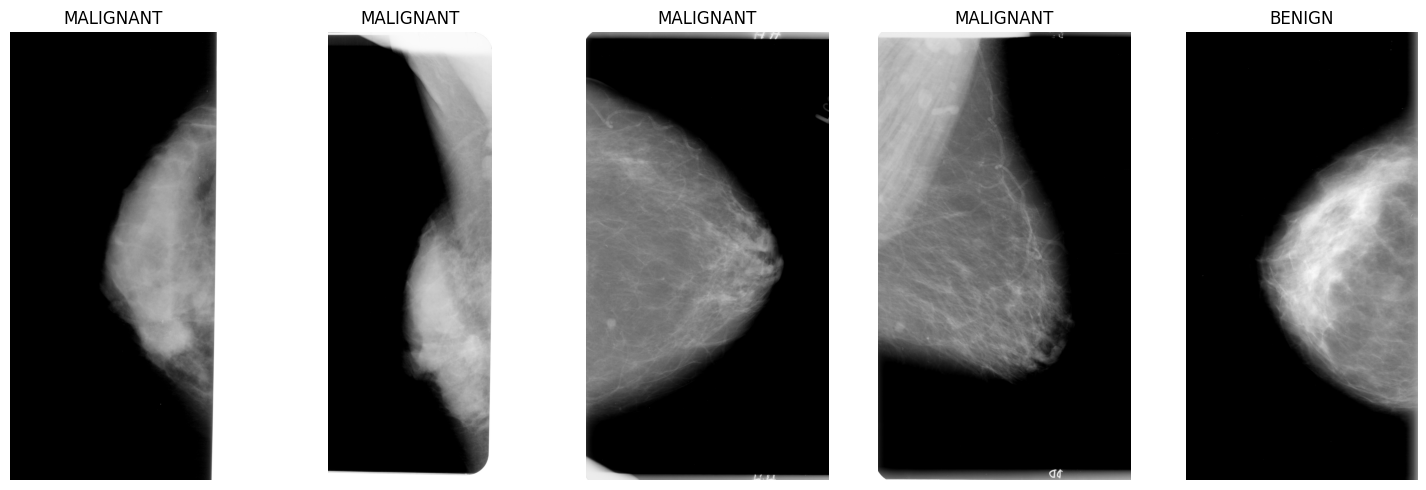

Cropped Mammograms:

(384, 385, 3)
(369, 328, 3)
(214, 195, 3)
(220, 225, 3)
(405, 376, 3)


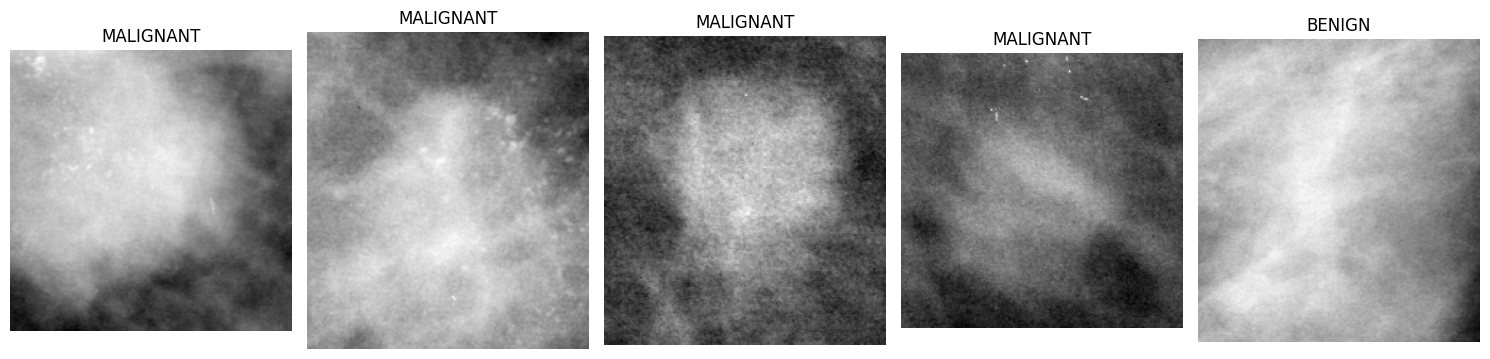

ROI_mask:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


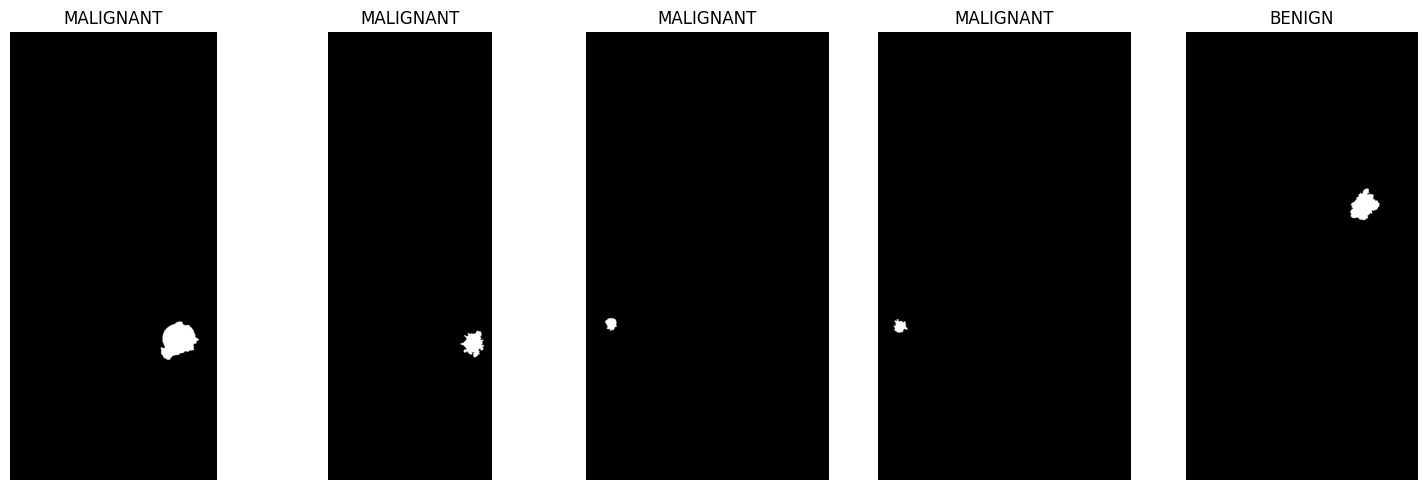

In [ ]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


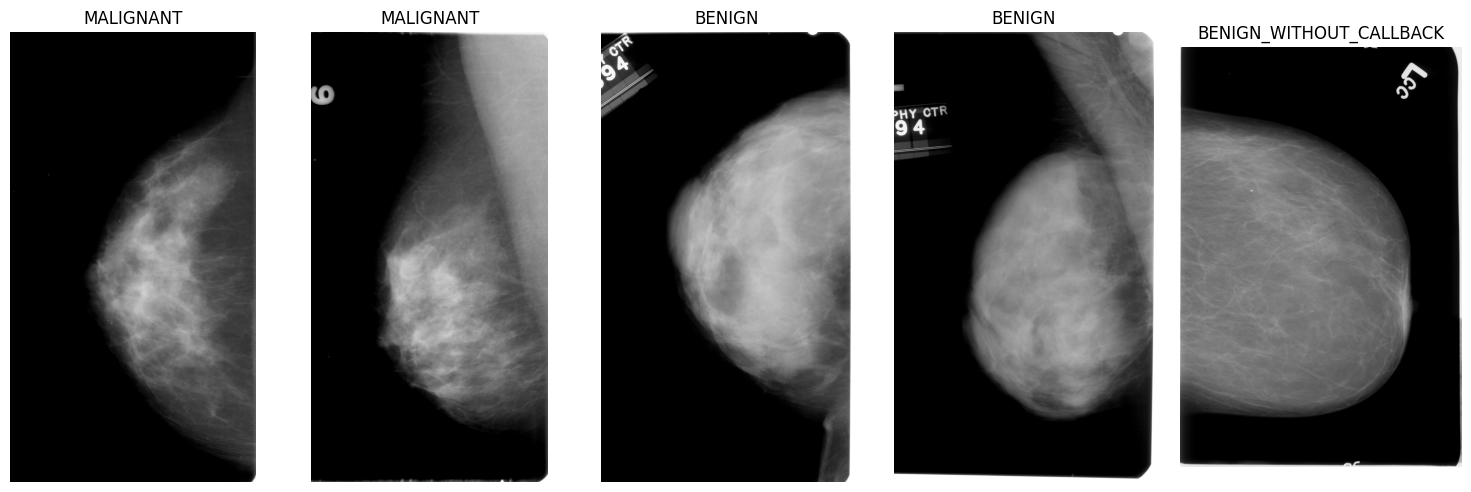

Cropped Mammograms:

(589, 677, 3)
(549, 681, 3)
(681, 577, 3)
(689, 761, 3)
(161, 177, 3)


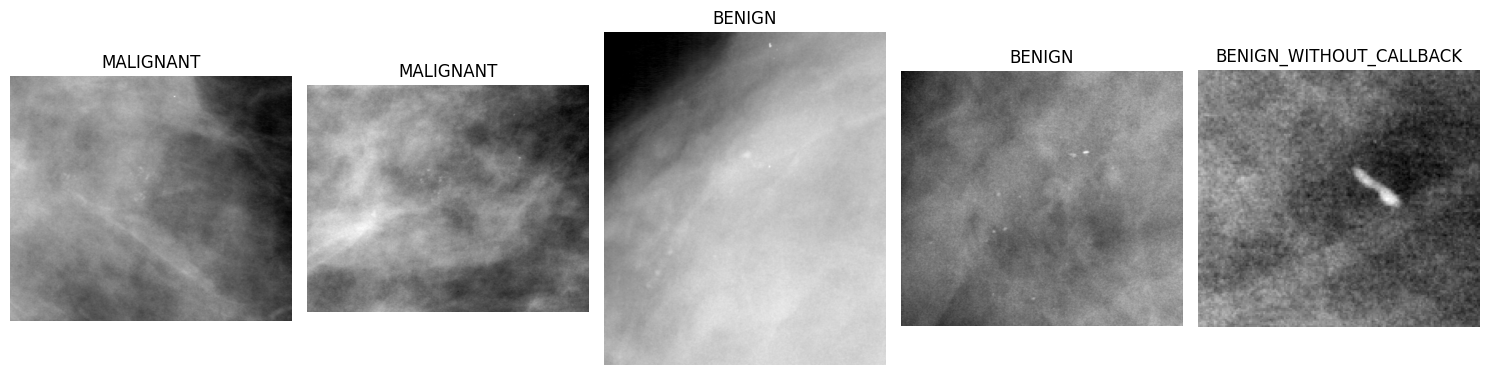

ROI_mask:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


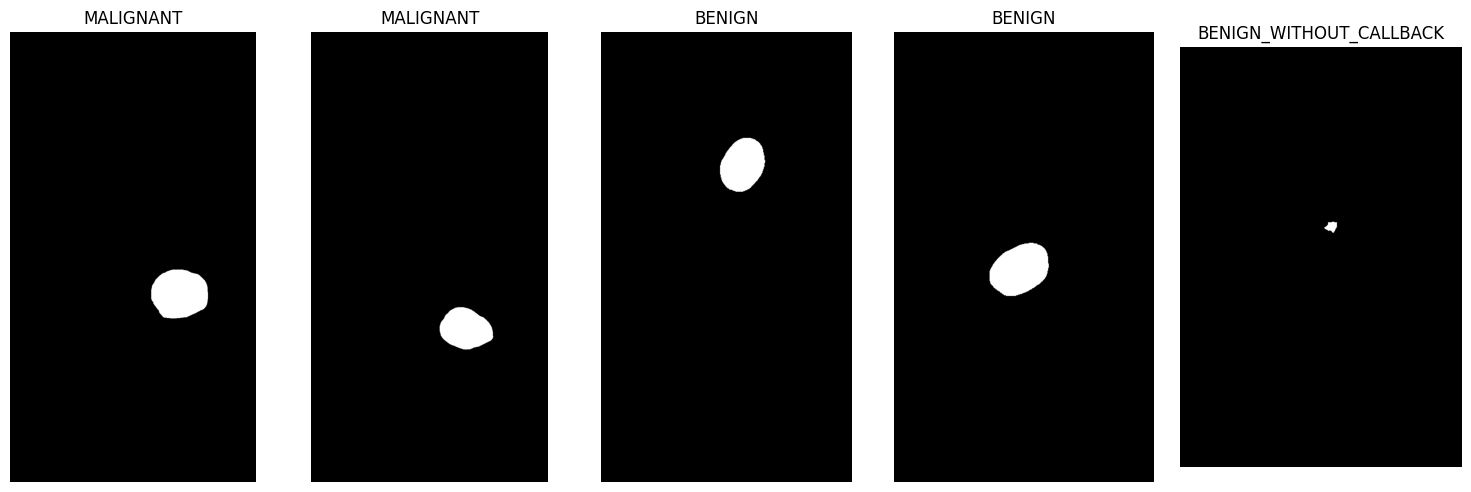

In [ ]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

In [ ]:
full_dataset = pd.concat([calc_train, calc_test], axis=0)

In [ ]:
del mass_train, mass_test, calc_train, calc_test;    gc.collect()

97718

In [ ]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

In [ ]:
target_size = (224, 224, 3)

In [ ]:
# Apply class mapper to pathology column
full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

<ipython-input-61-88e61f5e36a7>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


In [ ]:
len(full_images)

1870

In [ ]:

full_labels_series = pd.Series(full_labels)

label_counts = full_labels_series.value_counts()

benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)

print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

Benign images: 1198
Malignant images: 672


In [ ]:
num_classes = len(full_dataset['labels'].unique())
num_classes

2

In [ ]:
class_names = ['Benign', 'Malignant']

In [ ]:
dir_path = '/content/'

for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)

    if file_path == '/content/drive' or file_path.startswith('/content/drive/'):
        continue

    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("All files and subdirectories in '/content/' have been removed (except /content/drive).")

All files and subdirectories in '/content/' have been removed (except /content/drive).


In [ ]:
def images_count():
    zero_class_count = len(os.listdir("/content/merged_images/0"))
    one_class_count  = len(os.listdir("/content/merged_images/1"))

    print(f"Number of images in class 0: {zero_class_count}")
    print(f"Number of images in class 1: {one_class_count}")

In [ ]:
!ls "/content/merged_images/0/"

ls: cannot access '/content/merged_images/0/': No such file or directory


In [ ]:
!cp "/content/drive/MyDrive/mias-mammography.zip" /content/
!unzip "/content/mias-mammography.zip" -d /content/MIAS

Archive:  /content/mias-mammography.zip
  inflating: /content/MIAS/Info.txt  
  inflating: /content/MIAS/all-mias.tar.gz  
  inflating: /content/MIAS/all-mias/Info.txt  
  inflating: /content/MIAS/all-mias/Licence.txt  
  inflating: /content/MIAS/all-mias/README  
  inflating: /content/MIAS/all-mias/mdb001.pgm  
  inflating: /content/MIAS/all-mias/mdb002.pgm  
  inflating: /content/MIAS/all-mias/mdb003.pgm  
  inflating: /content/MIAS/all-mias/mdb004.pgm  
  inflating: /content/MIAS/all-mias/mdb005.pgm  
  inflating: /content/MIAS/all-mias/mdb006.pgm  
  inflating: /content/MIAS/all-mias/mdb007.pgm  
  inflating: /content/MIAS/all-mias/mdb008.pgm  
  inflating: /content/MIAS/all-mias/mdb009.pgm  
  inflating: /content/MIAS/all-mias/mdb010.pgm  
  inflating: /content/MIAS/all-mias/mdb011.pgm  
  inflating: /content/MIAS/all-mias/mdb012.pgm  
  inflating: /content/MIAS/all-mias/mdb013.pgm  
  inflating: /content/MIAS/all-mias/mdb014.pgm  
  inflating: /content/MIAS/all-mias/mdb015.pgm  


In [ ]:
!ls "/content/MIAS/all-mias"

Info.txt     mdb054.pgm  mdb109.pgm  mdb164.pgm  mdb219.pgm  mdb274.pgm
Licence.txt  mdb055.pgm  mdb110.pgm  mdb165.pgm  mdb220.pgm  mdb275.pgm
mdb001.pgm   mdb056.pgm  mdb111.pgm  mdb166.pgm  mdb221.pgm  mdb276.pgm
mdb002.pgm   mdb057.pgm  mdb112.pgm  mdb167.pgm  mdb222.pgm  mdb277.pgm
mdb003.pgm   mdb058.pgm  mdb113.pgm  mdb168.pgm  mdb223.pgm  mdb278.pgm
mdb004.pgm   mdb059.pgm  mdb114.pgm  mdb169.pgm  mdb224.pgm  mdb279.pgm
mdb005.pgm   mdb060.pgm  mdb115.pgm  mdb170.pgm  mdb225.pgm  mdb280.pgm
mdb006.pgm   mdb061.pgm  mdb116.pgm  mdb171.pgm  mdb226.pgm  mdb281.pgm
mdb007.pgm   mdb062.pgm  mdb117.pgm  mdb172.pgm  mdb227.pgm  mdb282.pgm
mdb008.pgm   mdb063.pgm  mdb118.pgm  mdb173.pgm  mdb228.pgm  mdb283.pgm
mdb009.pgm   mdb064.pgm  mdb119.pgm  mdb174.pgm  mdb229.pgm  mdb284.pgm
mdb010.pgm   mdb065.pgm  mdb120.pgm  mdb175.pgm  mdb230.pgm  mdb285.pgm
mdb011.pgm   mdb066.pgm  mdb121.pgm  mdb176.pgm  mdb231.pgm  mdb286.pgm
mdb012.pgm   mdb067.pgm  mdb122.pgm  mdb177.pgm  mdb232.pgm  mdb

In [ ]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm

# 1. Set your paths (update these if different)
MIAS_DIR = "/content/MIAS/"  # Where you extracted the files
OUTPUT_DIR = "/content/processed_images"  # Where to save processed images

# 2. Load metadata
def load_mias_metadata():
    info_path = os.path.join(MIAS_DIR, "Info.txt")
    if not os.path.exists(info_path):
        raise FileNotFoundError(f"Info.txt not found at {info_path}")

    data = []
    with open(info_path, 'r') as f:
        for _ in range(6): next(f)  # Skip headers
        for line in f:
            if line.strip():
                parts = line.split()
                ref_num = parts[0]
                severity = parts[3] if len(parts) > 3 else 'B'  # Default to benign
                data.append({
                    'ref_num': ref_num,
                    'label': 0 if severity == 'B' else 1  # 0=Benign, 1=Malignant
                })
    return pd.DataFrame(data)

# 3. Process images with progress tracking
def process_images():
    metadata_df = load_mias_metadata()
    image_dir = os.path.join(MIAS_DIR, "all-mias")

    # Create output directories
    os.makedirs(os.path.join(OUTPUT_DIR, "0"), exist_ok=True)  # Benign
    os.makedirs(os.path.join(OUTPUT_DIR, "1"), exist_ok=True)  # Malignant

    processed_counts = {'0': 0, '1': 0}
    errors = []

    for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Processing MIAS Images"):
        img_path = os.path.join(image_dir, f"{row['ref_num']}.pgm")
        if not os.path.exists(img_path):
            errors.append(f"Missing: {img_path}")
            continue

        try:
            with Image.open(img_path) as img:

                img = img.convert('RGB').resize((224, 224))


                class_dir = str(row['label'])
                output_path = os.path.join(OUTPUT_DIR, class_dir, f"{row['ref_num']}.jpg")
                img.save(output_path, "JPEG", quality=95)
                processed_counts[class_dir] += 1

        except Exception as e:
            errors.append(f"Error processing {img_path}: {str(e)}")

    return processed_counts, errors

# 4. Run the processing
print("Starting MIAS dataset processing...")
counts, errors = process_images()

# 5. Display results
print("\nProcessing complete!")
print(f"Benign images processed: {counts['0']}")
print(f"Malignant images processed: {counts['1']}")
print(f"Total processed: {sum(counts.values())}")

if errors:
    print(f"\nEncountered {len(errors)} issues:")
    for error in errors[:5]:  # Show first 5 errors
        print(error)
    if len(errors) > 5:
        print(f"... and {len(errors)-5} more")
else:
    print("\nAll images processed successfully!")

# 6. Verify output
print("\nOutput directory structure:")
!tree -L 2 {OUTPUT_DIR}

Starting MIAS dataset processing...


Processing MIAS Images: 100%|██████████| 325/325 [00:03<00:00, 86.86it/s]



Processing complete!
Benign images processed: 271
Malignant images processed: 54
Total processed: 325

All images processed successfully!

Output directory structure:
/bin/bash: line 1: tree: command not found


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 35.9 MB/s eta 0:00:00


In [ ]:
!unzip "/content/drive/MyDrive/archive.zip" -d /content/CBIS-DDSM

Streaming output truncated to the last 5000 lines.
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295326067813319071803507885093865003464/1-076.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/1-265.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295334798611650724727702371150477767947/2-266.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295394441612082321922200964343746626621/1-002.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295397487412067903910787953980192002590/1-233.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/1-294.jpg  
  inflating: /content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295400289412664594307776853882592114725/2-223.jpg  
  inflating: /content/CBIS-DDSM/jpeg/

In [ ]:
import os
import random
import uuid
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm import tqdm

def images_count(directory="/content/merged_images"):
    try:
        zero_class = os.path.join(directory, "0")
        one_class = os.path.join(directory, "1")
        zero_count = len([f for f in os.listdir(zero_class) if f.endswith(('.jpg', '.jpeg', '.png'))])
        one_count = len([f for f in os.listdir(one_class) if f.endswith(('.jpg', '.jpeg', '.png'))])
        print(f"Number of images in class 0: {zero_count}")
        print(f"Number of images in class 1: {one_count}")
        return zero_count, one_count
    except FileNotFoundError as e:
        print(f"Error counting images: {e}")
        return 0, 0


def augment_image(image):
    """Apply random augmentations to image"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image

def resize_image(image_tensor):
    """Resize image to standard size"""
    return tf.image.resize(image_tensor, [224, 224])

def load_mias_metadata(info_file_path):
    """Load and parse the MIAS Info.txt file"""
    data = []
    with open(info_file_path, 'r') as f:
        for _ in range(6):
            next(f)

        for line in f:
            if line.strip() == "":
                continue

            ref_num = line[0:6].strip()
            bg_tissue = line[7:8].strip()
            abnormality = line[9:13].strip()
            severity = line[14:15].strip()
            x_coord = line[16:20].strip()
            y_coord = line[21:25].strip()
            radius = line[26:].strip()

            data.append({
                'ref_num': ref_num,
                'bg_tissue': bg_tissue,
                'abnormality': abnormality,
                'severity': severity,
                'x_coord': x_coord if x_coord else None,
                'y_coord': y_coord if y_coord else None,
                'radius': radius if radius else None
            })

    return pd.DataFrame(data)

def augment_images(image_list, dest_dir, num_augments):
    """Generate augmented versions of images"""
    if not image_list or num_augments <= 0:
        return

    print(f"Generating {num_augments} augmented images...")

    for i in tqdm(range(num_augments), desc="Augmenting"):
        try:
            src_path = random.choice(image_list)
            with Image.open(src_path) as img:
                img = img.convert("RGB")
                img_tensor = tf.convert_to_tensor(img)
                augmented = augment_image(img_tensor)
                pil_img = tf.keras.preprocessing.image.array_to_img(augmented)


                base = os.path.splitext(os.path.basename(src_path))[0]
                new_name = f"{base}_aug{i}_{uuid.uuid4().hex[:4]}.jpg"
                pil_img.save(os.path.join(dest_dir, new_name), "JPEG")

        except Exception as e:
            print(f"\nAugmentation error for {os.path.basename(src_path)}: {e}")


def process_mias_dataset(image_paths, labels, output_dir="/content/merged_images"):
    """Process MIAS mammography dataset with proper error handling"""

    if len(image_paths) != len(labels):
        raise ValueError("Number of images and labels must match")

    counts = {"0": 0, "1": 0}
    skipped = []
    processed_images = {"0": [], "1": []}


    for cls in ["0", "1"]:
        os.makedirs(os.path.join(output_dir, cls), exist_ok=True)

    print(f"\nProcessing {len(image_paths)} images...")

    for img_path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Processing"):
        label_str = str(label)

        if not os.path.exists(img_path):
            skipped.append(img_path)
            continue

        try:
            ext = os.path.splitext(img_path)[1]
            filename = f"{uuid.uuid4().hex}{ext}"
            output_path = os.path.join(output_dir, label_str, filename)

            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')

                img_tensor = tf.convert_to_tensor(img)
                resized_img = resize_image(img_tensor)
                augmented_img = augment_image(resized_img)

                pil_img = tf.keras.preprocessing.image.array_to_img(augmented_img)
                pil_img.save(output_path, "JPEG", quality=90)

                counts[label_str] += 1
                processed_images[label_str].append(output_path)

        except Exception as e:
            print(f"\nError processing {os.path.basename(img_path)}: {str(e)}")
            skipped.append(img_path)


    print("\nInitial processing complete:")
    print(f"- Benign (0): {counts['0']} images")
    print(f"- Malignant (1): {counts['1']} images")
    print(f"- Skipped: {len(skipped)}")

    if counts["0"] > 0 and counts["1"] > 0:
        imbalance = counts["0"] - counts["1"]
        if imbalance != 0:
            minority = "1" if imbalance > 0 else "0"
            needed = abs(imbalance)
            print(f"\nBalancing classes by augmenting {needed} {'malignant' if minority == '1' else 'benign'} images")
            augment_images(processed_images[minority],
                         os.path.join(output_dir, minority),
                         needed)

    target_count = 5000
    print("\nPerforming final augmentation to reach target count...")

    for cls in ["0", "1"]:
        current_count = len(os.listdir(os.path.join(output_dir, cls)))
        if current_count < target_count:
            needed = target_count - current_count
            print(f"Augmenting {needed} more images for class {cls}")
            augment_images(processed_images[cls],
                         os.path.join(output_dir, cls),
                         needed)

    print("\nFinal counts:")
    images_count(output_dir)

    return processed_images


if __name__ == "__main__":

    from google.colab import drive
    drive.mount('/content/drive')


    base_dir = "/content/MIAS"
    info_file = os.path.join(base_dir, "Info.txt")
    image_dir = os.path.join(base_dir, "all-mias")
    destination_dir = "/content/merged_images"


    if not os.path.exists(info_file):
        raise FileNotFoundError(f"MIAS Info.txt not found at: {info_file}")
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found at: {image_dir}")

    print("Loading MIAS metadata...")
    metadata_df = load_mias_metadata(info_file)

    image_paths = []
    labels = []
    severity_map = {'B': 0, 'M': 1}

    print("\nPreparing image paths and labels...")
    for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Processing metadata"):

        pgm_file = f"{row['ref_num'].lower()}.pgm"
        pgm_path = os.path.join(image_dir, pgm_file)

        if os.path.exists(pgm_path):
            image_paths.append(pgm_path)
            labels.append(severity_map.get(row['severity'], 0))
        else:
            print(f"Warning: Image not found - {pgm_file}")

    print(f"\nFound {len(image_paths)} images with labels")
    print("Class distribution before processing:")
    print(pd.Series(labels).value_counts().to_string())

    processed = process_mias_dataset(
        image_paths=image_paths,
        labels=labels,
        output_dir=destination_dir
    )


    print("\nProcessing complete!")
    print(f"Output directory: {destination_dir}")
    print("\nFinal class distribution:")
    images_count(destination_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading MIAS metadata...

Preparing image paths and labels...


Processing metadata: 100%|██████████| 325/325 [00:00<00:00, 12382.24it/s]



Found 325 images with labels
Class distribution before processing:
0    271
1     54

Processing 325 images...


Processing: 100%|██████████| 325/325 [00:12<00:00, 25.30it/s]



Initial processing complete:
- Benign (0): 271 images
- Malignant (1): 54 images
- Skipped: 0

Balancing classes by augmenting 217 malignant images
Generating 217 augmented images...


Augmenting: 100%|██████████| 217/217 [00:04<00:00, 46.04it/s]



Performing final augmentation to reach target count...
Augmenting 4729 more images for class 0
Generating 4729 augmented images...


Augmenting: 100%|██████████| 4729/4729 [00:40<00:00, 115.38it/s]


Augmenting 4729 more images for class 1
Generating 4729 augmented images...


Augmenting: 100%|██████████| 4729/4729 [00:40<00:00, 118.15it/s]


Final counts:
Number of images in class 0: 4729
Number of images in class 1: 4946

Processing complete!
Output directory: /content/merged_images

Final class distribution:
Number of images in class 0: 4729
Number of images in class 1: 4946


In [ ]:
images_count()

Number of images in class 0: 4729
Number of images in class 1: 4946


(4729, 4946)

In [ ]:
data_dir = '/content/merged_images'

if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset directory not found at: {data_dir}. "
                          "Please ensure you've run the preprocessing code first.")

full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=30,
    shuffle=True,
    batch_size=13
)

total_samples = len(full_dataset)
print(f"Total batches in dataset: {total_samples}")

train_size = int(0.7 * total_samples)
test_size = total_samples - train_size

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"\nDataset split complete:")
print(f"Training batches:   {len(train_dataset)} (approx {len(train_dataset)*13} images)")
print(f"Test batches:       {len(test_dataset)} (approx {len(test_dataset)*13} images)")


del full_dataset
gc.collect()

Found 9675 files belonging to 2 classes.
Total batches in dataset: 745

Dataset split complete:
Training batches:   521 (approx 6773 images)
Test batches:       224 (approx 2912 images)


0

In [ ]:

from keras import backend as K

# Load dataset with validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/merged_images',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/merged_images',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Paths
PROJECT_PATH = "/content/"
CHECKPOINTS_DIR = os.path.join(PROJECT_PATH, "Checkpoints")
LOGS_DIR = os.path.join(PROJECT_PATH, "Logs")

def make_file():
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    os.makedirs(LOGS_DIR, exist_ok=True)

def reset_memory():
    K.clear_session()
    gc.collect()

def create_model(trainable_layers, dropout_value):
    base_model = EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    for layer in base_model.layers:
        layer.trainable = False

    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - trainable_layers / 100.0)))
    for layer in base_model.layers[from_index:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_value)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def run_model(trainable_layers=20,
              dropout_value=0.3,
              save=True,
              epochs=10,
              patience=3):

    reset_memory()
    model = create_model(trainable_layers, dropout_value)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

    callbacks = [
        TerminateOnNaN(),
        EarlyStopping(monitor="val_accuracy", mode="max", patience=patience, restore_best_weights=True)
    ]

    if save:
        make_file()
        checkpointPath = os.path.join(CHECKPOINTS_DIR, "EffNetB0_best_model.weights.h5")
        fullModelPath = os.path.join(CHECKPOINTS_DIR, "EffNetB0_full_model.h5")
        csvLogPath = os.path.join(LOGS_DIR, "EffNetB0_training_log.csv")
        callbacks += [
            ModelCheckpoint(checkpointPath,
                            save_best_only=True,
                            save_weights_only=True,
                            monitor="val_accuracy",
                            mode="max"),
            CSVLogger(csvLogPath, append=True)
        ]

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=callbacks
    )

    # Save full model
    if save:
        model.save(fullModelPath)
        print(f"✅ Full model saved to: {fullModelPath}")
        print(f"✅ Weights saved to: {checkpointPath}")

    # Evaluate on validation set
    val_loss, val_acc, val_precision, val_recall = model.evaluate(val_dataset)
    print("\n Validation Results:")
    print(f"   🔹 Loss:      {val_loss:.4f}")
    print(f"   🔹 Accuracy:  {val_acc:.4f}")
    print(f"   🔹 Precision: {val_precision:.4f}")
    print(f"   🔹 Recall:    {val_recall:.4f}")

    return model, history

Found 9675 files belonging to 2 classes.
Using 7740 files for training.
Found 9675 files belonging to 2 classes.
Using 1935 files for validation.


In [ ]:
model, history = run_model(epochs=11, trainable_layers=20, dropout_value=0.4)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/11
242/242 ━━━━━━━━━━━━━━━━━━━━ 83s 179ms/step - accuracy: 0.8309 - loss: 0.3609 - precision: 0.8309 - recall: 0.8309 - val_accuracy: 0.9933 - val_loss: 0.0264 - val_precision: 0.9933 - val_recall: 0.9933
Epoch 2/11
242/242 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - accuracy: 0.9666 - loss: 0.0931 - precision: 0.9666 - recall: 0.9666 - val_accuracy: 0.9969 - val_loss: 0.0145 - val_precision: 0.9969 - val_recall: 0.9969
Epoch 3/11
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9776 - loss: 0.0595 - precision: 0.9776 - recall: 0.9776 - val_accuracy: 0.9953 - val_loss: 0.0118 - val_precision: 0.9953 - val_recall: 0.9953
Epoch 4/11
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.9849 - loss: 0.0444 - precision: 0.9849 - recall: 0.9849 - val_accuracy: 0.9948 - val_loss: 0.0109 - val_precision: 0.9948 - val_recall: 0.9948
Epoch 5/11
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9803 - loss: 0.0508 - precision:

✅ Full model saved to: /content/Checkpoints/EffNetB0_full_model.h5
✅ Weights saved to: /content/Checkpoints/EffNetB0_best_model.weights.h5
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9980 - loss: 0.0068 - precision: 0.9980 - recall: 0.9980

📊 Validation Results:
   🔹 Loss:      0.0090
   🔹 Accuracy:  0.9974
   🔹 Precision: 0.9974
   🔹 Recall:    0.9974


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 14,441,176 (55.09 MB)

 Trainable params: 3,604,034 (13.75 MB)

 Non-trainable params: 3,629,072 (13.84 MB)

 Optimizer params: 7,208,070 (27.50 MB)

In [ ]:
print(len(model.layers))

274


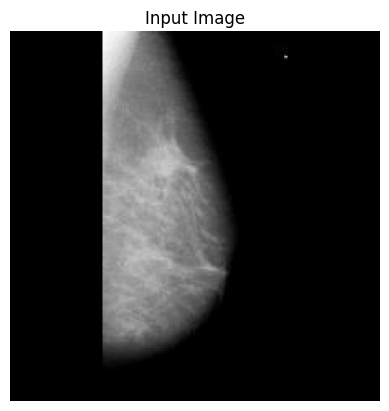

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Raw Prediction: [[0.21529068 0.78470933]]
Predicted Class: 1


3875

In [ ]:
image_dir = '/content/merged_images/1/'
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])

# Read the image with OpenCV (BGR format by default)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize to model input size
image = cv2.resize(image, (224, 224))

# Normalize and expand dimensions for batch input
image = image / 255.0
image = np.expand_dims(image, axis=0)

# Display the image
plt.imshow(image[0])
plt.title("Input Image")
plt.axis('off')
plt.show()

# Make prediction using the trained model
result = model.predict(image)
print("Raw Prediction:", result)

# Display class prediction
predicted_class = np.argmax(result)
print("Predicted Class:", predicted_class)

# Clean up memory
del image; gc.collect()

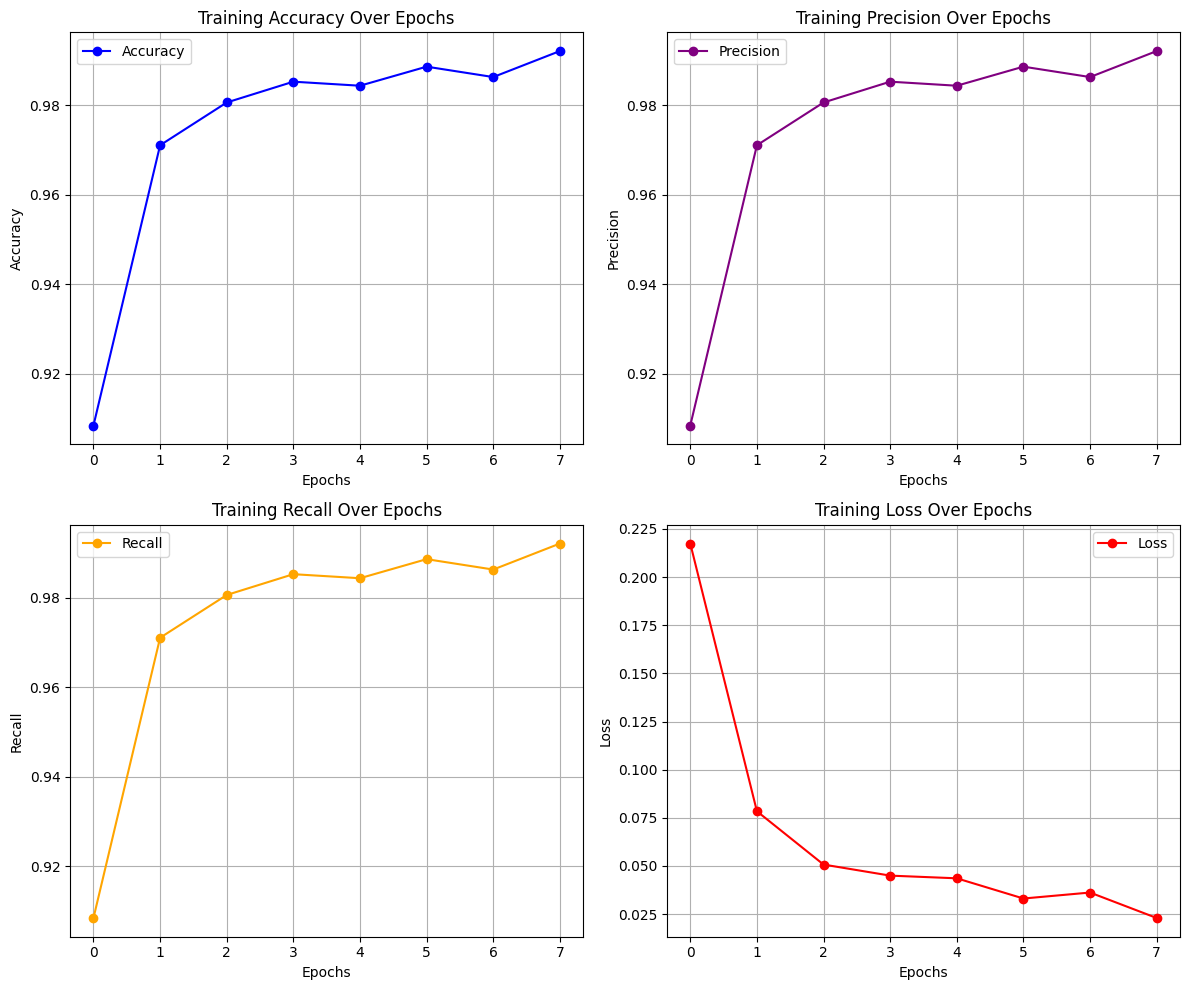

In [ ]:
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']

epochs = range(len(train_accuracy))

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

metrics = [('Accuracy', train_accuracy, 'blue'),
           ('Precision', train_precision, 'purple'),
           ('Recall', train_recall, 'orange'),
           ('Loss', train_loss, 'red')]

for ax, (title, values, color) in zip(axs.ravel(), metrics):
    ax.plot(epochs, values, label=title, color=color, marker='o')
    ax.set_title(f'Training {title} Over Epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(title)
    ax.grid(True)
    ax.legend()



plt.tight_layout()
plt.savefig('training_metrics_grid.png')
plt.show()


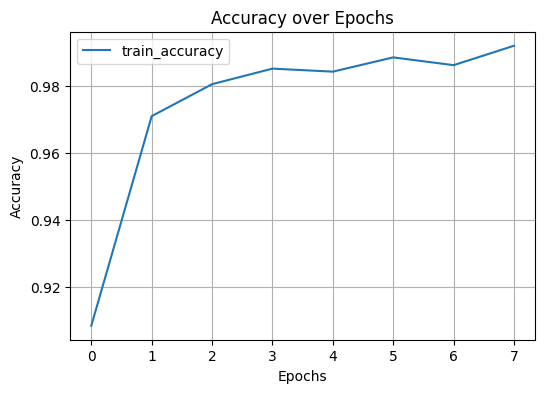

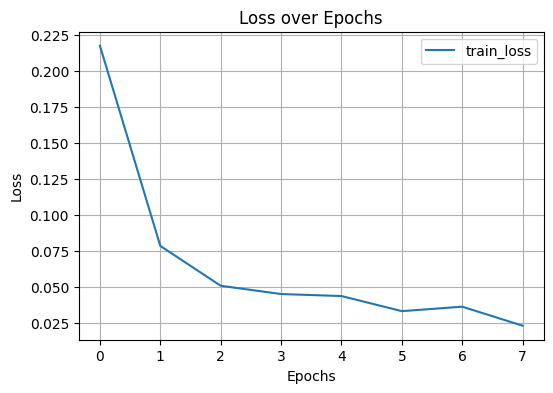

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    metrics = ['accuracy', 'loss']
    for m in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history[m], label=f"train_{m}")
        plt.title(f'{m.capitalize()} over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(m.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

# After training
plot_training(history)


             Layer Name      Weight Name           Type   Shape
0               stem_bn            gamma  Non-Trainable    [32]
1               stem_bn             beta  Non-Trainable    [32]
2               stem_bn      moving_mean  Non-Trainable    [32]
3               stem_bn  moving_variance  Non-Trainable    [32]
4    block1a_project_bn            gamma  Non-Trainable    [16]
..                  ...              ...            ...     ...
231  block6h_project_bn  moving_variance  Non-Trainable   [192]
232              top_bn            gamma      Trainable  [1280]
233              top_bn             beta      Trainable  [1280]
234              top_bn      moving_mean  Non-Trainable  [1280]
235              top_bn  moving_variance  Non-Trainable  [1280]

[236 rows x 4 columns]

🔢 Total BatchNorm Parameters: 121216


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━

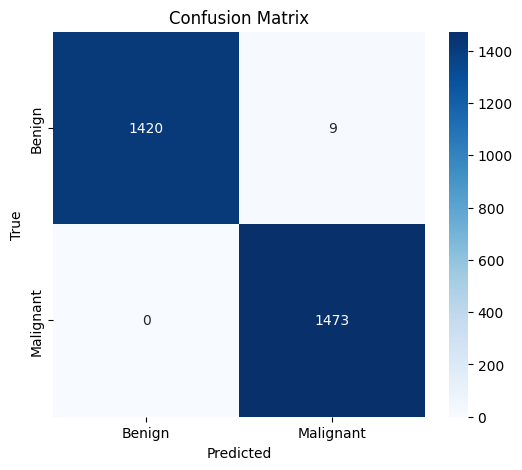

Classification Report:

              precision    recall  f1-score   support

      Benign       1.00      0.99      1.00      1429
   Malignant       0.99      1.00      1.00      1473

    accuracy                           1.00      2902
   macro avg       1.00      1.00      1.00      2902
weighted avg       1.00      1.00      1.00      2902



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for batch in test_dataset:
    images, labels = batch
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: 1 (Malignant)
Prediction Probability: 1.0000


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


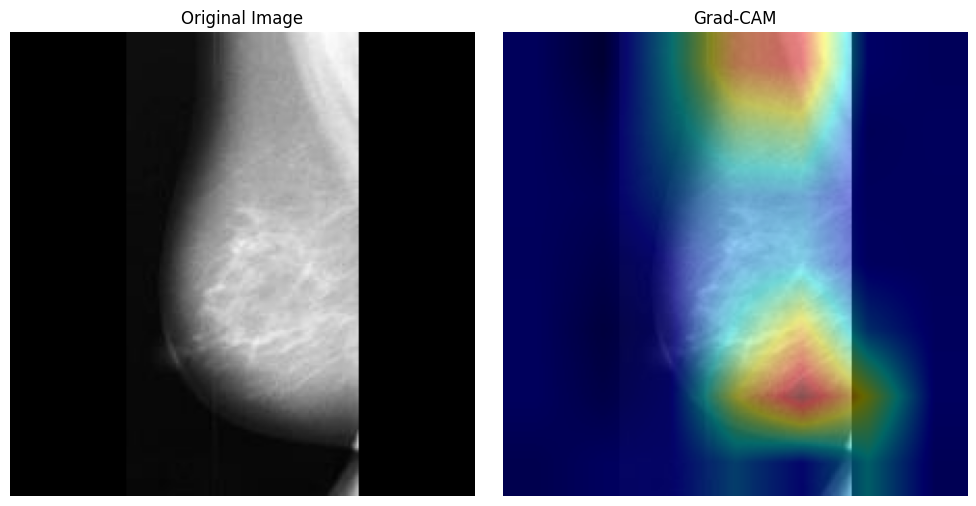

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------------
# Function to load and preprocess image
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# -------------------------------
# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# -------------------------------
# Function to display heatmap on original image
def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load original image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    # Resize heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert heatmap to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Superimpose heatmap on image
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Display
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# -------------------------------
# Load your model
model = tf.keras.models.load_model("/content/Checkpoints/EffNetB0_full_model.h5")

# Image path and processing
img_path = "/content/merged_images/1/d59cbbe0a8974508a7256700422e9b37_aug2038_c221.jpg"
img_array = get_img_array(img_path, size=(224, 224))

# Predict class
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
confidence = preds[0][predicted_class]
class_names = ['Benign', 'Malignant']

print(f"Predicted Class: {predicted_class} ({class_names[predicted_class]})")
print(f"Prediction Probability: {confidence:.4f}")

# Generate Grad-CAM - Using the last convolutional layer from your model
# Looking at your error, we can see this is an EfficientNet-based model
last_conv_layer_name = "top_activation"  # Common last conv layer in EfficientNet
try:
    heatmap = make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=predicted_class)
except ValueError:
    # If the first try fails, let's find the last convolutional layer
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 4:  # 4D output means convolutional layer
            last_conv_layer_name = layer.name
            print(f"Found last conv layer: {last_conv_layer_name}")
            break
    heatmap = make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=predicted_class)

# Display Grad-CAM
display_gradcam(img_path, heatmap)

In [ ]:
!ls "/content/merged_images/1/"

00aaa6f7a19d4481954f11db27eb592d_aug1012_27d4.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1075_e564.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1090_7a6c.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1111_bb33.jpg
00aaa6f7a19d4481954f11db27eb592d_aug139_fdb0.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1405_140b.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1501_9a12.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1600_7eeb.jpg
00aaa6f7a19d4481954f11db27eb592d_aug161_99e1.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1644_f35b.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1760_3bc8.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1766_4b99.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1775_b1e5.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1798_f54e.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1851_80b0.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1867_3039.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1891_e44d.jpg
00aaa6f7a19d4481954f11db27eb592d_aug1973_2812.jpg
00aaa6f7a19d4481954f11db27eb592d_aug2077_2407.jpg
00aaa6f7a19d4481954f11db27eb592d_aug2092_bb76.jpg
00